# 10/29

In [43]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from datetime import datetime

# Multi-task: reconsturction and variability prediction

### Data preprocessing

In [50]:
# Helper function to clean and fix variability labels
def clean_variability_label(label):
    label = label.lower()
    if "periodic" in label:
        return "periodic"
    elif "aperiodic" in label:
        return "aperiodic"
    elif "not" in label:
        return "not variable"
    else:
        print(label)

class LightCurveDataset(Dataset):
    def __init__(self, files, sequence_length=1000):
        self.files = files
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load CSV file (skip metadata rows)
        df = pd.read_csv(self.files[idx], skiprows=9)

        # Convert to tensors
        stdmag = torch.tensor(df['StdMag'].values, dtype=torch.float32)
        time_point = torch.tensor(df['Time'].values, dtype=torch.float32)
        
        # Pad or truncate sequences to fixed length
        seq_len = len(stdmag)
        if seq_len > self.sequence_length:
            start_idx = random.randint(0, seq_len - self.sequence_length)
            stdmag = stdmag[start_idx:start_idx + self.sequence_length]
            time_point = time_point[start_idx:start_idx + self.sequence_length]
            seq_len = self.sequence_length
        else:
            padding = self.sequence_length - seq_len
            stdmag = torch.cat([stdmag, torch.zeros(padding)])
            time_point = torch.cat([time_point, torch.zeros(padding)])

        # Generate masks for masking intervals
        mask = torch.zeros(self.sequence_length, dtype=torch.bool)

        # Randomly select number of intervals (1 to 5)
        num_intervals = random.randint(1, 5)
        masked_indices = set()

        for _ in range(num_intervals):
            overlap = True
            attempt = 0

            while overlap and attempt < 10: # Limit the number of attempts to prevent infinite loops
                # Randomly select start index
                start_idx = random.randint(0, seq_len - 1)

                # Randomly determine length (1% to 5% of sequence length)
                interval_length = max(1, int(self.sequence_length * random.uniform(0.01, 0.05)))
                end_idx = min(start_idx + interval_length, self.sequence_length)

                # Check for overlap with existing masked indices
                overlap = any(i in masked_indices for i in range(start_idx, end_idx))
                attempt += 1

            if not overlap:
                # Mask the interval if there is no overlap
                for i in range(start_idx, end_idx):
                    mask[i] = True
                    masked_indices.add(i)

        # Define a special index for the [MASK] token
        MASK_TOKEN = -1  # This will be recognized by the model as the [MASK] token

        # Create masked input by replacing masked positions with zero
        masked_stdmag = stdmag.clone()
        masked_stdmag[mask] = MASK_TOKEN  # You can use a learnable [MASK] token instead

        # Variability type label
        try:
            metadata = pd.read_csv(self.files[idx], nrows=5, header=None)
            variability_type = metadata.iloc[3, 1]
            variability_type = clean_variability_label(str(variability_type))
        except (IndexError, AttributeError, KeyError):
            variability_type = 'not variable'
        label = torch.tensor(label_encoder.transform([variability_type])[0], dtype=torch.long)

        return masked_stdmag, time_point, mask, stdmag, label
    
# Smoothing function
def smooth_curve(values, window_size=10):
    """Apply a moving average filter to smooth the curve."""
    if len(values) == 0:
        # Return the values unchanged if there are no elements
        return values
    
    if len(values) < window_size:
        # If the number of values is smaller than the window size, reduce the window size
        window_size = len(values)

    # Apply padding and smoothing
    padded_values = F.pad(values.unsqueeze(0), (window_size // 2, window_size // 2), mode='reflect').squeeze(0)
    smoothed_values = torch.conv1d(padded_values.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, window_size) / window_size).squeeze()
    
    # Ensure the output length matches the input length by trimming any extra elements due to padding
    smoothed_values = smoothed_values[:len(values)]
    return smoothed_values


### Load Data

In [51]:
# Load data from CSV
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Separate datasets
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)

# Create separate datasets
train_dataset = LightCurveDataset(train_files)
val_dataset = LightCurveDataset(val_files)
test_dataset = LightCurveDataset(test_files)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Label encoder for variability type
label_encoder = LabelEncoder()

# Preprocess labels
variability_types = []
for file in files:
    try:
        metadata = pd.read_csv(file, nrows=5, header=None)
        variability = metadata.iloc[3, 1]
        variability = clean_variability_label(str(variability))
        variability_types.append(variability)
    except (IndexError, AttributeError, KeyError):
        variability_types.append('not variable')
label_encoder.fit(variability_types)

LabelEncoder()

### Model

In [52]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=128, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        # Initialize an empty positional encoding matrix with dimensions (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Angular frequency (div_term)
        div_term = 1 / (1000 ** (2 * torch.arange(0, d_model, 2).float() / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term) # Even index dimensions
        pe[:, 1::2] = torch.cos(position * div_term) # Odd index dimensions

        # Add a batch dimension and transpose for compatibility
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, nhead=4, num_layers=2, d_model=128, output_dim=3, max_len=1000):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len) #nn.Linear(1, d_model)
        
        # Define a learnable embedding for the [MASK] token
        self.mask_token_embedding = nn.Parameter(torch.randn(d_model)) #default parameter values are extracted from Gaussain distribution

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.reconstruction_head = nn.Linear(d_model, 1)
        self.classification_head = nn.Linear(d_model, output_dim) #output_dim = 3(periodic, aperiodic, non-variable)

    def forward(self, x, time_point):
        MASK_TOKEN = -1
        # Identify masked positions and replace them with the mask token embedding
        mask_positions = (x == MASK_TOKEN).unsqueeze(-1)
        
        # Embed the StdMag values
        x = self.embedding(x.unsqueeze(-1))
        
        # Replace masked values with the learnable mask token embedding
        x = torch.where(mask_positions, self.mask_token_embedding, x)

        # Use time differences as positional encodings
        pos_enc = self.pos_encoder(time_point.unsqueeze(-1))

        # Add positional encodings to input
        x = x + pos_enc

        # Pass through transformer layers
        x = self.transformer(x)

        # Reconstruction output
        recon_output = self.reconstruction_head(x).squeeze(-1)

        # Classification output (use mean pooling)
        cls_output = self.classification_head(x.mean(dim=1))

        return recon_output, cls_output

### Additional settings

In [53]:
#LRScheduler
class LRScheduler():
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=1
        )
    
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

#Early stopping
path = "model.pth"

class EarlyStopping():
    def __init__(self, patience=5, delta=0, verbose=1, path=path):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False #early stopping or not. default is False.
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'Early Stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Initialize early stopping
early_stopping = EarlyStopping(patience=5)

In [54]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize model
model = TransformerModel()

# Lists to store the loss history
train_losses = []
train_recon_losses = []
train_classif_losses = []
val_losses = []
val_recon_losses = []
val_classif_losses = []
num_epochs = 100
alpha = 0.6  # Weighting factor between reconstruction and classification losses

In [56]:
# Loss functions and optimizer
recon_criterion = nn.MSELoss()
classif_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_classif_loss = 0.0

    # Training step
    for masked_stdmag, time_point, mask, stdmag, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        recon_output, cls_output = model(masked_stdmag, time_point)

        # Smooth the actual StdMag values for the masked regions
        smoothed_stdmag = stdmag.clone()
        for i in range(stdmag.size(0)):  # Iterate over the batch
            smoothed_stdmag[i][mask[i]] = smooth_curve(stdmag[i][mask[i]])  # Smooth only masked parts

        # Compute reconstruction loss with smoothed masked values
        if mask.sum() > 0:
            recon_loss = recon_criterion(recon_output[mask], smoothed_stdmag[mask])
        else:
            recon_loss = torch.tensor(0.0, requires_grad=True)

        # Compute classification loss
        classif_loss = classif_criterion(cls_output, labels)

        # Total loss (weighted sum of reconstruction and classification losses)
        total_loss = alpha * recon_loss + (1 - alpha) * classif_loss

        total_loss.backward()
        optimizer.step()

        # Track losses
        train_loss += total_loss.item()
        train_recon_loss += recon_loss.item()
        train_classif_loss += classif_loss.item()

    # Average the losses
    train_loss /= len(train_loader)
    train_recon_loss /= len(train_loader)
    train_classif_loss /= len(train_loader)

    train_losses.append(train_loss)
    train_recon_losses.append(train_recon_loss)
    train_classif_losses.append(train_classif_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_classif_loss = 0.0

    with torch.no_grad():
        for masked_stdmag, time_point, mask, stdmag, labels in val_loader:
            recon_output, cls_output = model(masked_stdmag, time_point)

            # Smooth the actual StdMag values for validation masked regions
            smoothed_stdmag = stdmag.clone()
            for i in range(stdmag.size(0)):
                smoothed_stdmag[i][mask[i]] = smooth_curve(stdmag[i][mask[i]])

            recon_loss = recon_criterion(recon_output[mask], smoothed_stdmag[mask])
            classif_loss = classif_criterion(cls_output, labels)

            val_loss += (recon_loss + classif_loss).item()
            val_recon_loss += recon_loss.item()
            val_classif_loss += classif_loss.item()

    # Average the validation losses
    val_loss /= len(val_loader)
    val_recon_loss /= len(val_loader)
    val_classif_loss /= len(val_loader)

    val_losses.append(val_loss)
    val_recon_losses.append(val_recon_loss)
    val_classif_losses.append(val_classif_loss)

    # Print loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Recon Loss: {val_recon_loss:.4f}, Classif Loss: {val_classif_loss:.4f}")

    # Early stopping logic (if implemented)
    early_stopping(val_loss, model=model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Evaluate the model on the test set
all_labels = []
all_preds = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for masked_stdmag, time_point, mask, stdmag, labels in test_loader:
        _, cls_output = model(masked_stdmag, time_point)
        preds = torch.argmax(cls_output, dim=1)
        all_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())

Epoch 1, Train Loss: 1.9163, Val Loss: 3.4154, Recon Loss: 2.7539, Classif Loss: 0.6615
Validation loss decreased (inf --> 3.415395). Saving model ...
Epoch 2, Train Loss: 1.5118, Val Loss: 3.6362, Recon Loss: 2.8226, Classif Loss: 0.8136
Early Stopping counter: 1 out of 5
Epoch 3, Train Loss: 1.5668, Val Loss: 2.7243, Recon Loss: 2.1166, Classif Loss: 0.6077
Validation loss decreased (3.415395 --> 2.724287). Saving model ...
Epoch 4, Train Loss: 1.2969, Val Loss: 2.3703, Recon Loss: 1.8076, Classif Loss: 0.5628
Validation loss decreased (2.724287 --> 2.370338). Saving model ...
Epoch 5, Train Loss: 1.1509, Val Loss: 2.9025, Recon Loss: 2.2332, Classif Loss: 0.6694
Early Stopping counter: 1 out of 5
Epoch 6, Train Loss: 1.1468, Val Loss: 1.8843, Recon Loss: 1.2877, Classif Loss: 0.5966
Validation loss decreased (2.370338 --> 1.884320). Saving model ...
Epoch 7, Train Loss: 0.9696, Val Loss: 2.0171, Recon Loss: 1.4014, Classif Loss: 0.6157
Early Stopping counter: 1 out of 5
Epoch 8, Tra

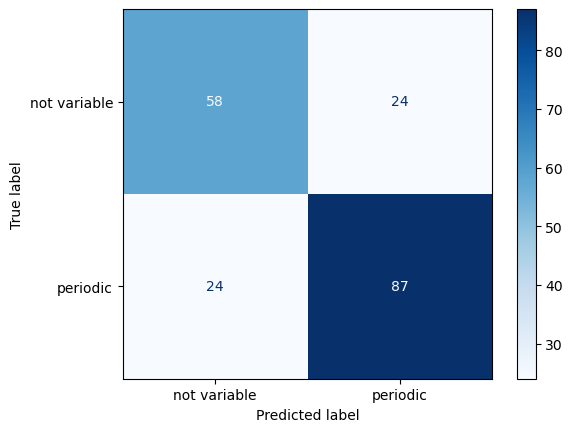

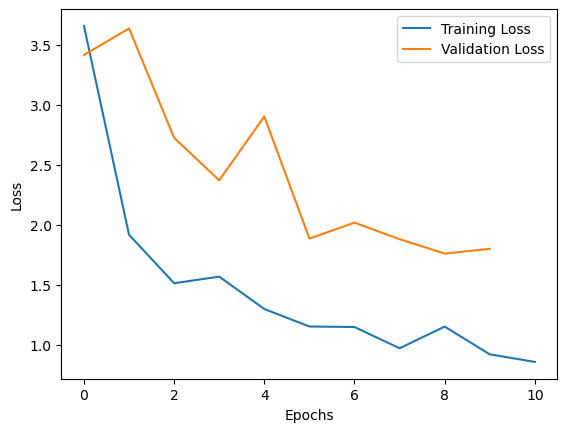

In [57]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

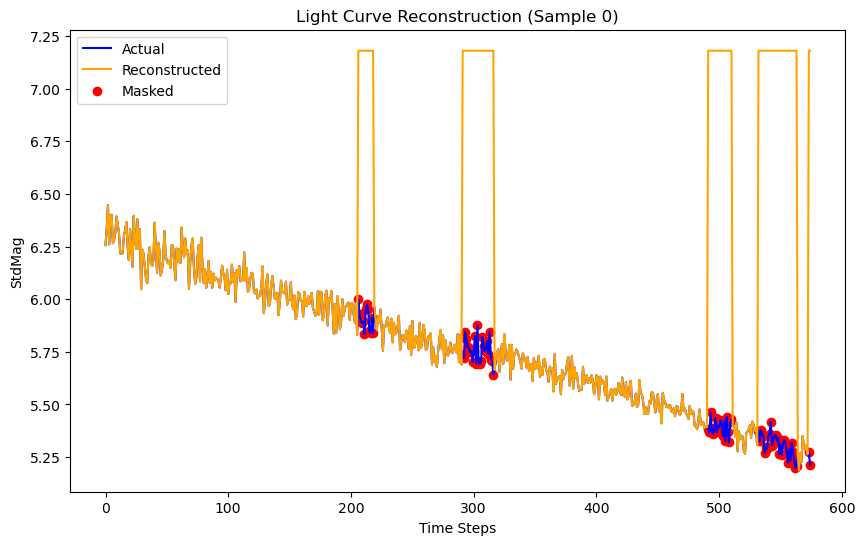

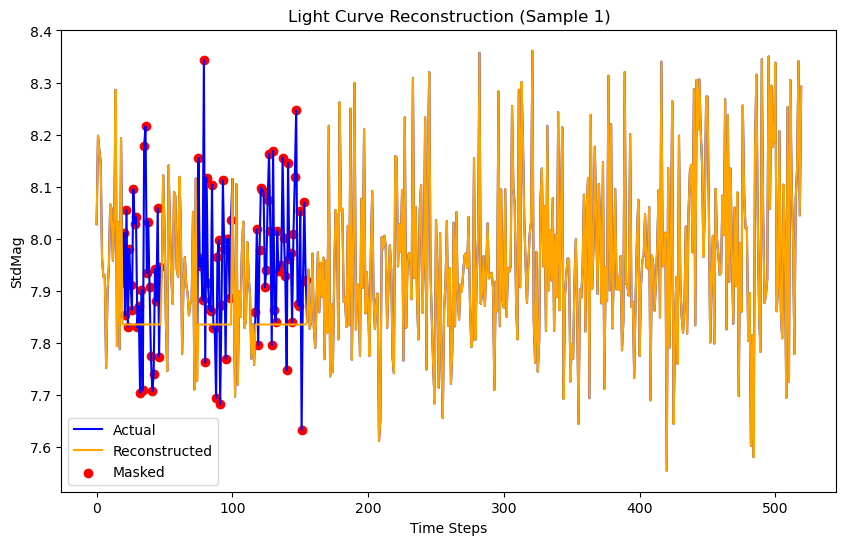

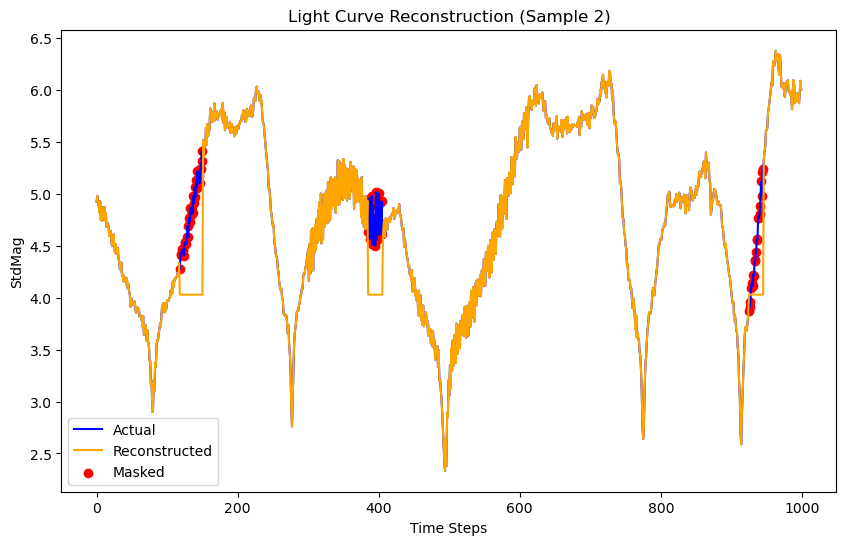

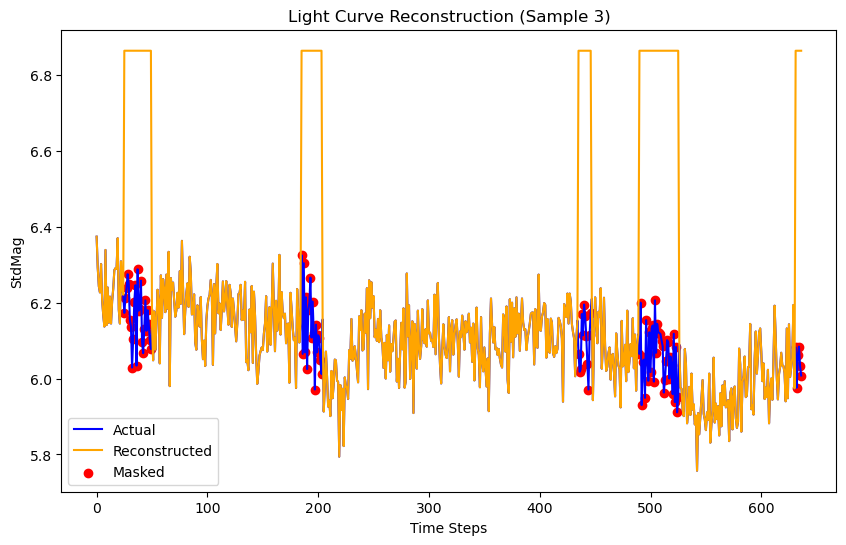

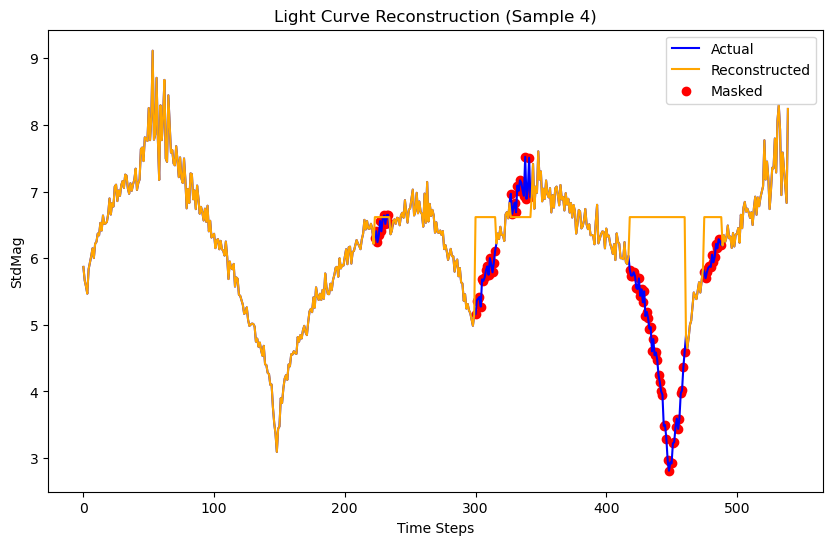

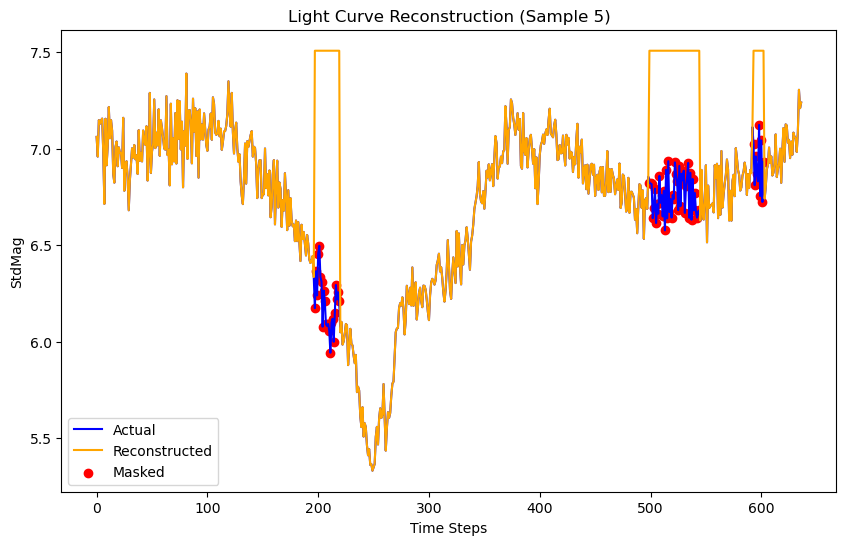

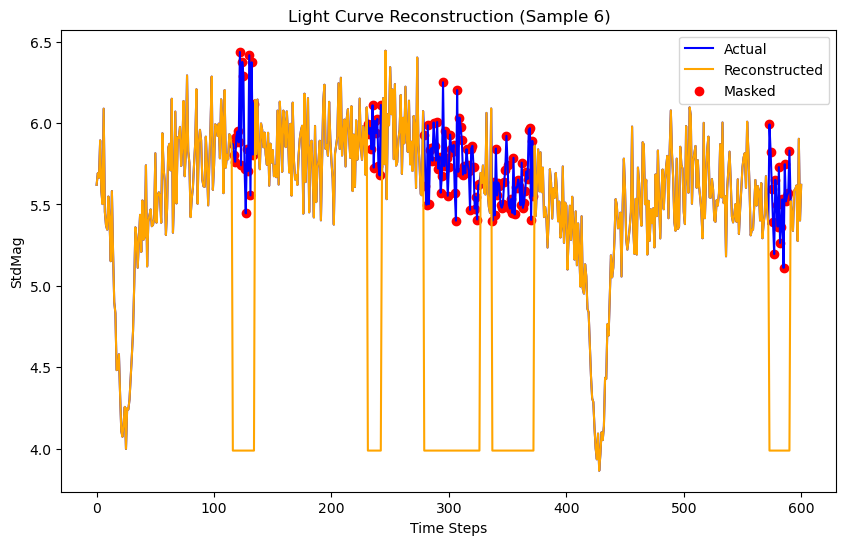

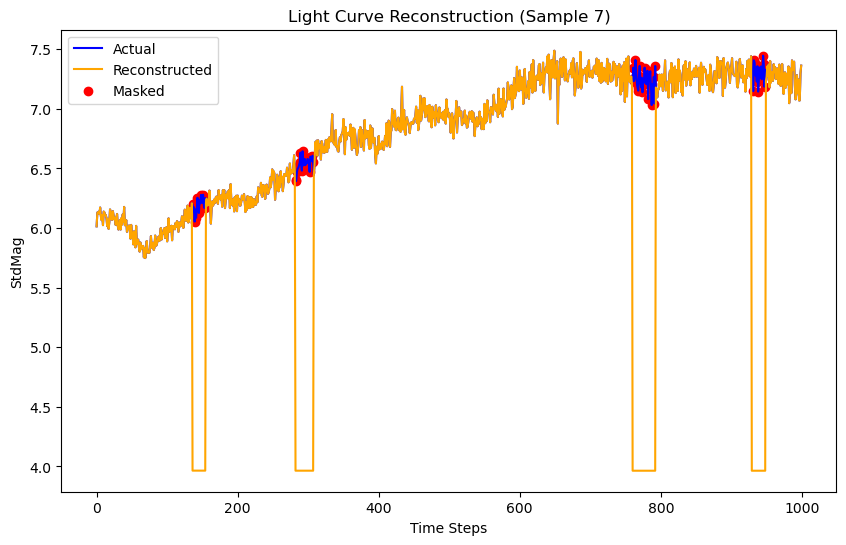

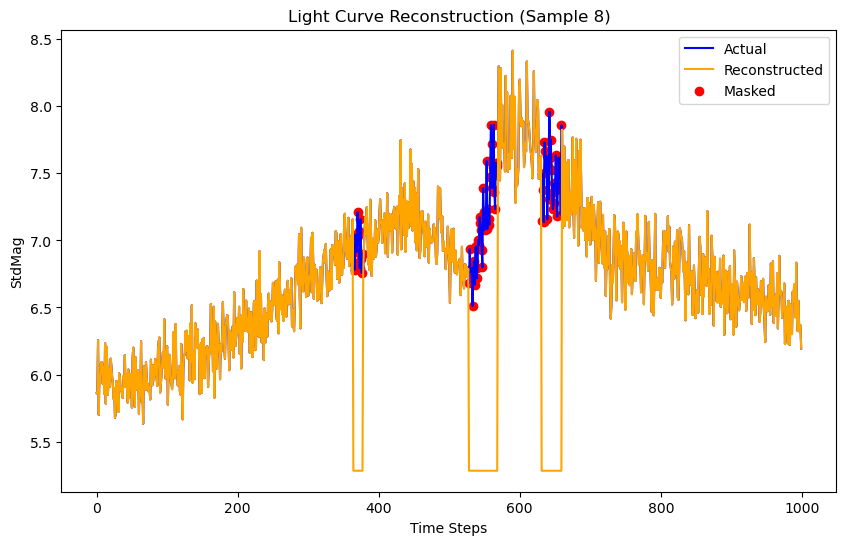

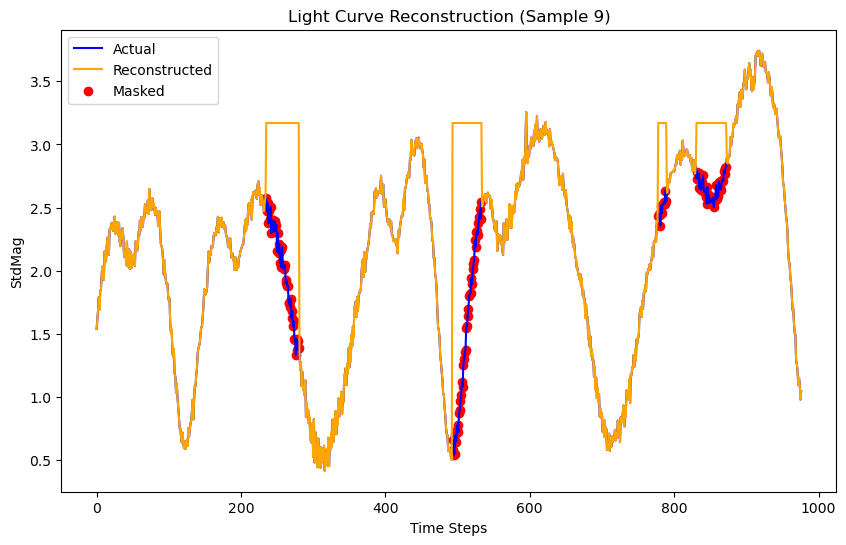

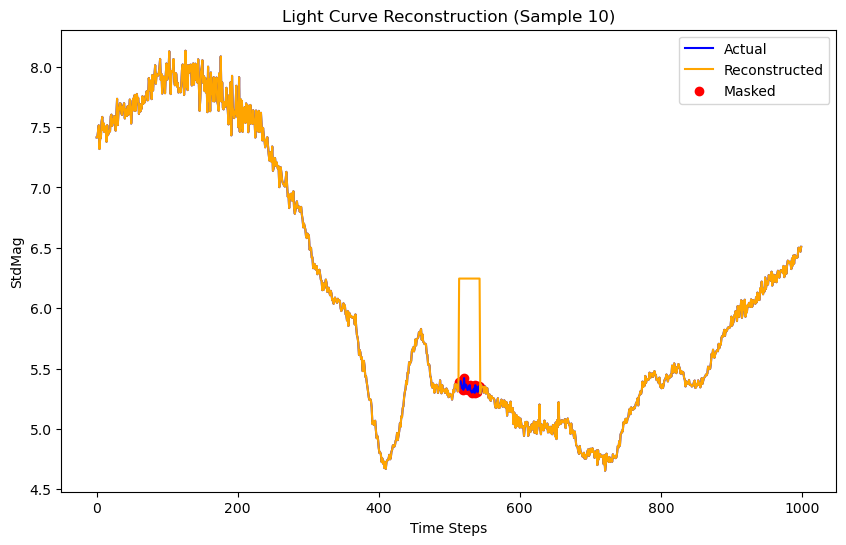

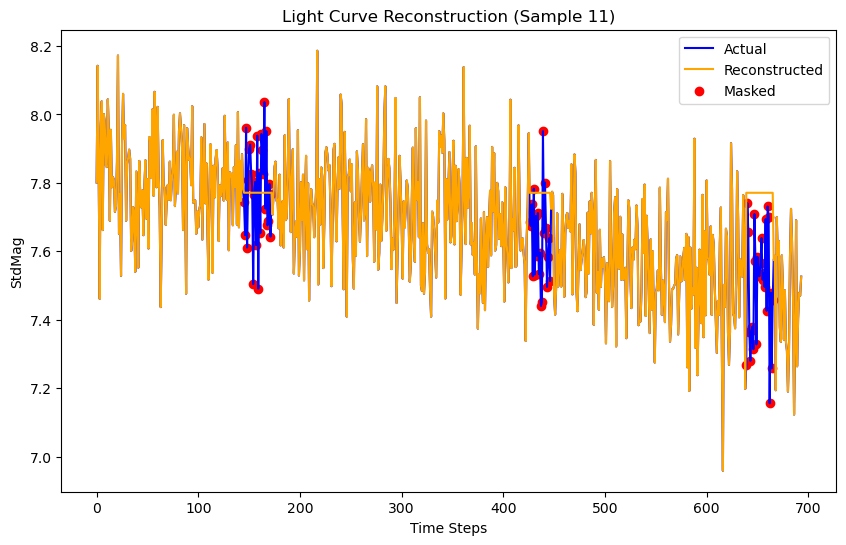

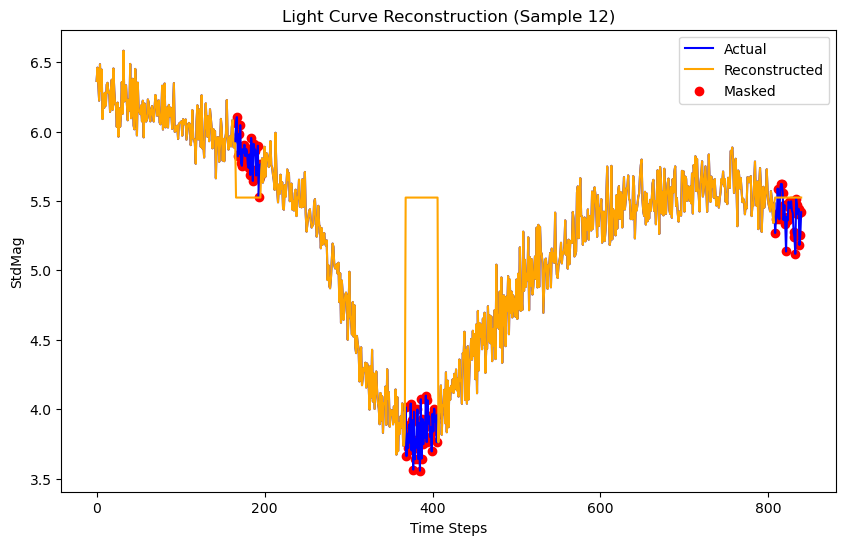

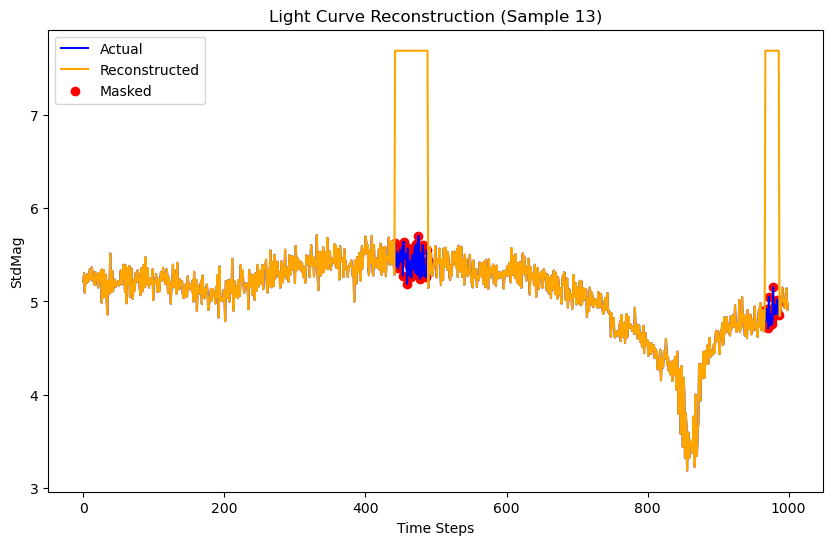

KeyboardInterrupt: 

In [58]:
def visualize_reconstruction(num_samples=5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (masked_stdmag, time_point, mask, stdmag, labels) in enumerate(test_loader):
            if i >= num_samples:
                break  # Visualize only the first `num_samples`
            
            recon_output, _ = model(masked_stdmag, time_point)
            
            for j in range(masked_stdmag.size(0)):  # Iterate over batch
                plt.figure(figsize=(10, 6))
                
                # Filter out zero values (assuming zeros were used as padding)
                non_zero_indices = stdmag[j].cpu().nonzero().flatten()
                
                # Plot actual StdMag, excluding zero values
                plt.plot(non_zero_indices, stdmag[j].cpu()[non_zero_indices], label='Actual', color='blue')
                
                # Plot reconstructed StdMag only for masked parts, excluding zero values
                reconstructed = stdmag[j].cpu().clone()  # Start with actual values
                reconstructed[mask[j].cpu()] = recon_output[j].cpu()[mask[j].cpu()]  # Replace masked points
                plt.plot(non_zero_indices, reconstructed[non_zero_indices], label='Reconstructed', color='orange')
                
                # Highlight masked parts (where the reconstruction was done), excluding zeros
                masked_non_zero_indices = non_zero_indices[mask[j].cpu()[non_zero_indices]]
                plt.scatter(masked_non_zero_indices, stdmag[j].cpu()[masked_non_zero_indices], color='red', label='Masked')

                plt.title(f'Light Curve Reconstruction (Sample {j})')
                plt.xlabel('Time Steps')
                plt.ylabel('StdMag')
                plt.legend()
                plt.show()

visualize_reconstruction(num_samples=5)